# Ascon loacl code

In [ ]:
#!/usr/bin/env python3

"""
Implementation of Ascon, an authenticated cipher and hash function
NIST SP 800-232
https://ascon.iaik.tugraz.at/
"""

debug = False
debugpermutation = False

# === Ascon hash/xof ===

def ascon_hash(message, variant="Ascon-Hash256", hashlength=32, customization=b""):
    """
    Ascon hash function and extendable-output function.
    message: a bytes object of arbitrary length
    variant: "Ascon-Hash256" (with 256-bit output for 128-bit security), "Ascon-XOF128", or "Ascon-CXOF128" (both with arbitrary output length, security=min(128, bitlen/2))
    hashlength: the requested output bytelength (must be 32 for variant "Ascon-Hash256"; can be arbitrary for Ascon-XOF128, but should be >= 32 for 128-bit security)
    customization: a bytes object of at most 256 bytes specifying the customization string (only for Ascon-CXOF128)
    returns a bytes object containing the hash tag
    """
    versions = {"Ascon-Hash256": 2,
                "Ascon-XOF128": 3,
                "Ascon-CXOF128": 4}
    assert variant in versions.keys()
    if variant == "Ascon-Hash256": assert hashlength == 32
    if variant == "Ascon-CXOF128": assert len(customization) <= 256
    else: assert len(customization) == 0
    a = b = 12 # rounds
    rate = 8 # bytes
    taglen = 256 if variant == "Ascon-Hash256" else 0
    customize = True if variant == "Ascon-CXOF128" else False

    # Initialization
    iv = to_bytes([versions[variant], 0, (b<<4) + a]) + int_to_bytes(taglen, 2) + to_bytes([rate, 0, 0])
    S = bytes_to_state(iv + zero_bytes(32))
    if debug: printstate(S, "initial value:")

    ascon_permutation(S, 12)
    if debug: printstate(S, "initialization:")

    # Customization
    if customize:
        z_padding = to_bytes([0x01]) + zero_bytes(rate - (len(customization) % rate) - 1)
        z_length = int_to_bytes(len(customization)*8, 8)
        z_padded = z_length + customization + z_padding

        # customization blocks 0,...,m
        for block in range(0, len(z_padded), rate):
            S[0] ^= bytes_to_int(z_padded[block:block+rate])
            ascon_permutation(S, 12)
        if debug: printstate(S, "customization:")

    # Message Processing (Absorbing)
    m_padding = to_bytes([0x01]) + zero_bytes(rate - (len(message) % rate) - 1)
    m_padded = message + m_padding

    # message blocks 0,...,n
    for block in range(0, len(m_padded), rate):
        S[0] ^= bytes_to_int(m_padded[block:block+rate])
        ascon_permutation(S, 12)
    if debug: printstate(S, "process message:")

    # Finalization (Squeezing)
    H = b""
    while len(H) < hashlength:
        H += int_to_bytes(S[0], rate)
        ascon_permutation(S, 12)
    if debug: printstate(S, "finalization:")
    return H[:hashlength]


# === Ascon MAC/PRF ===

def ascon_mac(key, message, variant="Ascon-Mac", taglength=16):
    """
    Ascon message authentication code (MAC) and pseudorandom function (PRF).
    key: a bytes object of size 16
    message: a bytes object of arbitrary length (<= 16 for "Ascon-PrfShort")
    variant: "Ascon-Mac" (128-bit output, arbitrarily long input), "Ascon-Prf" (arbitrarily long input and output), or "Ascon-PrfShort" (t-bit output for t<=128, m-bit input for m<=128)
    taglength: the requested output bytelength l/8 (must be <=16 for variants "Ascon-Mac" and "Ascon-PrfShort", arbitrary for "Ascon-Prf"; should be >= 16 for 128-bit security)
    returns a bytes object containing the authentication tag
    """
    assert variant in ["Ascon-Mac", "Ascon-Prf", "Ascon-PrfShort"]
    if variant == "Ascon-Mac": assert len(key) == 16 and taglength <= 16
    if variant == "Ascon-Prf": assert len(key) == 16
    if variant == "Ascon-PrfShort": assert len(key) == 16 and taglength <= 16 and len(message) <= 16
    a = b = 12  # rounds
    msgblocksize = 32 # bytes (input rate for Mac, Prf)
    rate = 16 # bytes (output rate)

    # TODO update IVs to be consistent with NIST format

    if variant == "Ascon-PrfShort":
        # Initialization + Message Processing (Absorbing)
        IV = to_bytes([len(key) * 8, len(message)*8, a + 64, taglength * 8]) + zero_bytes(4)
        S = bytes_to_state(IV + key + message + zero_bytes(16 - len(message)))
        if debug: printstate(S, "initial value:")

        ascon_permutation(S, a)
        if debug: printstate(S, "process message:")

        # Finalization (Squeezing)
        T = int_to_bytes(S[3] ^ bytes_to_int(key[0:8]), 8) + int_to_bytes(S[4] ^ bytes_to_int(key[8:16]), 8)
        return T[:taglength]

    else: # Ascon-Prf, Ascon-Mac
        # Initialization
        if variant == "Ascon-Mac": tagspec = int_to_bytes(16*8, 4)
        if variant == "Ascon-Prf": tagspec = int_to_bytes(0*8, 4)
        S = bytes_to_state(to_bytes([len(key) * 8, rate * 8, a + 128, a-b]) + tagspec + key + zero_bytes(16))
        if debug: printstate(S, "initial value:")

        ascon_permutation(S, a)
        if debug: printstate(S, "initialization:")

        # Message Processing (Absorbing)
        m_padding = to_bytes([0x01]) + zero_bytes(msgblocksize - (len(message) % msgblocksize) - 1)
        m_padded = message + m_padding

        # first s-1 blocks
        for block in range(0, len(m_padded) - msgblocksize, msgblocksize):
            S[0] ^= bytes_to_int(m_padded[block:block+8])     # msgblocksize=32 bytes
            S[1] ^= bytes_to_int(m_padded[block+8:block+16])
            S[2] ^= bytes_to_int(m_padded[block+16:block+24])
            S[3] ^= bytes_to_int(m_padded[block+24:block+32])
            ascon_permutation(S, b)
        # last block
        block = len(m_padded) - msgblocksize
        S[0] ^= bytes_to_int(m_padded[block:block+8])     # msgblocksize=32 bytes
        S[1] ^= bytes_to_int(m_padded[block+8:block+16])
        S[2] ^= bytes_to_int(m_padded[block+16:block+24])
        S[3] ^= bytes_to_int(m_padded[block+24:block+32])
        S[4] ^= 1
        if debug: printstate(S, "process message:")

        # Finalization (Squeezing)
        T = b""
        ascon_permutation(S, a)
        while len(T) < taglength:
            T += int_to_bytes(S[0], 8)  # rate=16
            T += int_to_bytes(S[1], 8)
            ascon_permutation(S, b)
        if debug: printstate(S, "finalization:")
        return T[:taglength]


# === Ascon AEAD encryption and decryption ===

def ascon_encrypt(key, nonce, associateddata, plaintext, variant="Ascon-AEAD128"):
    """
    Ascon encryption.
    key: a bytes object of size 16 (for Ascon-AEAD128; 128-bit security)
    nonce: a bytes object of size 16 (must not repeat for the same key!)
    associateddata: a bytes object of arbitrary length
    plaintext: a bytes object of arbitrary length
    variant: "Ascon-AEAD128"
    returns a bytes object of length len(plaintext)+16 containing the ciphertext and tag
    """
    versions = {"Ascon-AEAD128": 1}
    assert variant in versions.keys()
    assert len(key) == 16 and len(nonce) == 16
    S = [0, 0, 0, 0, 0]
    k = len(key) * 8   # bits
    a = 12   # rounds
    b = 8    # rounds
    rate = 16   # bytes

    ascon_initialize(S, k, rate, a, b, versions[variant], key, nonce)
    ascon_process_associated_data(S, b, rate, associateddata)
    ciphertext = ascon_process_plaintext(S, b, rate, plaintext)
    tag = ascon_finalize(S, rate, a, key)
    return ciphertext + tag


def ascon_decrypt(key, nonce, associateddata, ciphertext, variant="Ascon-AEAD128"):
    """
    Ascon decryption.
    key: a bytes object of size 16 (for Ascon-AEAD128; 128-bit security)
    nonce: a bytes object of size 16 (must not repeat for the same key!)
    associateddata: a bytes object of arbitrary length
    ciphertext: a bytes object of arbitrary length (also contains tag)
    variant: "Ascon-AEAD128"
    returns a bytes object containing the plaintext or None if verification fails
    """
    versions = {"Ascon-AEAD128": 1}
    assert variant in versions.keys()
    assert len(key) == 16 and len(nonce) == 16 and len(ciphertext) >= 16
    S = [0, 0, 0, 0, 0]
    k = len(key) * 8 # bits
    a = 12  # rounds
    b = 8   # rounds
    rate = 16   # bytes

    ascon_initialize(S, k, rate, a, b, versions[variant], key, nonce)
    ascon_process_associated_data(S, b, rate, associateddata)
    plaintext = ascon_process_ciphertext(S, b, rate, ciphertext[:-16])
    tag = ascon_finalize(S, rate, a, key)
    if tag == ciphertext[-16:]:
        return plaintext
    else:
        return None


# === Ascon AEAD building blocks ===

def ascon_initialize(S, k, rate, a, b, version, key, nonce):
    """
    Ascon initialization phase - internal helper function.
    S: Ascon state, a list of 5 64-bit integers
    k: key size in bits
    rate: block size in bytes (16 for Ascon-AEAD128)
    a: number of initialization/finalization rounds for permutation
    b: number of intermediate rounds for permutation
    version: 1 (for Ascon-AEAD128)
    key: a bytes object of size 16 (for Ascon-AEAD128; 128-bit security)
    nonce: a bytes object of size 16
    returns nothing, updates S
    """
    taglen = 128
    iv = to_bytes([version, 0, (b<<4) + a]) + int_to_bytes(taglen, 2) + to_bytes([rate, 0, 0])
    S[0], S[1], S[2], S[3], S[4] = bytes_to_state(iv + key + nonce)
    if debug: printstate(S, "initial value:")

    ascon_permutation(S, a)

    zero_key = bytes_to_state(zero_bytes(40-len(key)) + key)
    S[0] ^= zero_key[0]
    S[1] ^= zero_key[1]
    S[2] ^= zero_key[2]
    S[3] ^= zero_key[3]
    S[4] ^= zero_key[4]
    if debug: printstate(S, "initialization:")


def ascon_process_associated_data(S, b, rate, associateddata):
    """
    Ascon associated data processing phase - internal helper function.
    S: Ascon state, a list of 5 64-bit integers
    b: number of intermediate rounds for permutation
    rate: block size in bytes (16 for Ascon-AEAD128)
    associateddata: a bytes object of arbitrary length
    returns nothing, updates S
    """
    if len(associateddata) > 0:
        a_padding = to_bytes([0x01]) + zero_bytes(rate - (len(associateddata) % rate) - 1)
        a_padded = associateddata + a_padding

        for block in range(0, len(a_padded), rate):
            S[0] ^= bytes_to_int(a_padded[block:block+8])
            if rate == 16:
                S[1] ^= bytes_to_int(a_padded[block+8:block+16])

            ascon_permutation(S, b)

    S[4] ^= 1<<63
    if debug: printstate(S, "process associated data:")


def ascon_process_plaintext(S, b, rate, plaintext):
    """
    Ascon plaintext processing phase (during encryption) - internal helper function.
    S: Ascon state, a list of 5 64-bit integers
    b: number of intermediate rounds for permutation
    rate: block size in bytes (16 for Ascon-AEAD128)
    plaintext: a bytes object of arbitrary length
    returns the ciphertext (without tag), updates S
    """
    p_lastlen = len(plaintext) % rate
    p_padding = to_bytes([0x01]) + zero_bytes(rate-p_lastlen-1)
    p_padded = plaintext + p_padding

    # first t-1 blocks
    ciphertext = to_bytes([])
    for block in range(0, len(p_padded) - rate, rate):
        S[0] ^= bytes_to_int(p_padded[block:block+8])
        S[1] ^= bytes_to_int(p_padded[block+8:block+16])
        ciphertext += (int_to_bytes(S[0], 8) + int_to_bytes(S[1], 8))
        ascon_permutation(S, b)

    # last block t
    block = len(p_padded) - rate
    S[0] ^= bytes_to_int(p_padded[block:block+8])
    S[1] ^= bytes_to_int(p_padded[block+8:block+16])
    ciphertext += (int_to_bytes(S[0], 8)[:min(8,p_lastlen)] + int_to_bytes(S[1], 8)[:max(0,p_lastlen-8)])
    if debug: printstate(S, "process plaintext:")
    return ciphertext


def ascon_process_ciphertext(S, b, rate, ciphertext):
    """
    Ascon ciphertext processing phase (during decryption) - internal helper function.
    S: Ascon state, a list of 5 64-bit integers
    b: number of intermediate rounds for permutation
    rate: block size in bytes (16 for Ascon-AEAD128)
    ciphertext: a bytes object of arbitrary length
    returns the plaintext, updates S
    """
    c_lastlen = len(ciphertext) % rate
    c_padded = ciphertext + zero_bytes(rate - c_lastlen)

    # first t-1 blocks
    plaintext = to_bytes([])
    for block in range(0, len(c_padded) - rate, rate):
        Ci = (bytes_to_int(c_padded[block:block+8]), bytes_to_int(c_padded[block+8:block+16]))
        plaintext += (int_to_bytes(S[0] ^ Ci[0], 8) + int_to_bytes(S[1] ^ Ci[1], 8))
        S[0] = Ci[0]
        S[1] = Ci[1]
        ascon_permutation(S, b)

    # last block t
    block = len(c_padded) - rate
    c_padx = zero_bytes(c_lastlen) + to_bytes([0x01]) + zero_bytes(rate-c_lastlen-1)
    c_mask = zero_bytes(c_lastlen) + ff_bytes(rate-c_lastlen)
    Ci = (bytes_to_int(c_padded[block:block+8]), bytes_to_int(c_padded[block+8:block+16]))
    plaintext += (int_to_bytes(S[0] ^ Ci[0], 8) + int_to_bytes(S[1] ^ Ci[1], 8))[:c_lastlen]
    S[0] = (S[0] & bytes_to_int(c_mask[0:8]))  ^ Ci[0] ^ bytes_to_int(c_padx[0:8])
    S[1] = (S[1] & bytes_to_int(c_mask[8:16])) ^ Ci[1] ^ bytes_to_int(c_padx[8:16])
    if debug: printstate(S, "process ciphertext:")
    return plaintext


def ascon_finalize(S, rate, a, key):
    """
    Ascon finalization phase - internal helper function.
    S: Ascon state, a list of 5 64-bit integers
    rate: block size in bytes (16 for Ascon-AEAD128)
    a: number of initialization/finalization rounds for permutation
    key: a bytes object of size 16 (for Ascon-AEAD128; 128-bit security)
    returns the tag, updates S
    """
    assert len(key) == 16
    S[rate//8+0] ^= bytes_to_int(key[0:8])
    S[rate//8+1] ^= bytes_to_int(key[8:16])

    ascon_permutation(S, a)

    S[3] ^= bytes_to_int(key[-16:-8])
    S[4] ^= bytes_to_int(key[-8:])
    tag = int_to_bytes(S[3], 8) + int_to_bytes(S[4], 8)
    if debug: printstate(S, "finalization:")
    return tag


# === Ascon permutation ===

def ascon_permutation(S, rounds=1):
    """
    Ascon core permutation for the sponge construction - internal helper function.
    S: Ascon state, a list of 5 64-bit integers
    rounds: number of rounds to perform
    returns nothing, updates S
    """
    assert rounds <= 12
    if debugpermutation: printwords(S, "permutation input:")
    for r in range(12-rounds, 12):
        # --- add round constants ---
        S[2] ^= (0xf0 - r*0x10 + r*0x1)
        if debugpermutation: printwords(S, "round constant addition:")
        # --- substitution layer ---
        S[0] ^= S[4]
        S[4] ^= S[3]
        S[2] ^= S[1]
        T = [(S[i] ^ 0xFFFFFFFFFFFFFFFF) & S[(i+1)%5] for i in range(5)]
        for i in range(5):
            S[i] ^= T[(i+1)%5]
        S[1] ^= S[0]
        S[0] ^= S[4]
        S[3] ^= S[2]
        S[2] ^= 0XFFFFFFFFFFFFFFFF
        if debugpermutation: printwords(S, "substitution layer:")
        # --- linear diffusion layer ---
        S[0] ^= rotr(S[0], 19) ^ rotr(S[0], 28)
        S[1] ^= rotr(S[1], 61) ^ rotr(S[1], 39)
        S[2] ^= rotr(S[2],  1) ^ rotr(S[2],  6)
        S[3] ^= rotr(S[3], 10) ^ rotr(S[3], 17)
        S[4] ^= rotr(S[4],  7) ^ rotr(S[4], 41)
        if debugpermutation: printwords(S, "linear diffusion layer:")


# === helper functions ===

def get_random_bytes(num):
    import os
    return to_bytes(os.urandom(num))

def zero_bytes(n):
    return n * b"\x00"

def ff_bytes(n):
    return n * b"\xFF"

def to_bytes(l): # where l is a list or bytearray or bytes
    return bytes(bytearray(l))

def bytes_to_int(bytes):
    return sum([bi << (i*8) for i, bi in enumerate(to_bytes(bytes))])

def bytes_to_state(bytes):
    return [bytes_to_int(bytes[8*w:8*(w+1)]) for w in range(5)]

def int_to_bytes(integer, nbytes):
    return to_bytes([(integer >> (i * 8)) % 256 for i in range(nbytes)])

def rotr(val, r):
    return (val >> r) | ((val & (1<<r)-1) << (64-r))

def bytes_to_hex(b):
    return b.hex()
    #return "".join(x.encode('hex') for x in b)

def printstate(S, description=""):
    print(" " + description)
    print(" ".join(["{s:016x}".format(s=s) for s in S]))

def printwords(S, description=""):
    print(" " + description)
    print("\n".join(["  x{i}={s:016x}".format(**locals()) for i, s in enumerate(S)]))


# === some demo if called directly ===

def demo_print(data):
    maxlen = max([len(text) for (text, val) in data])
    for text, val in data:
        print("{text}:{align} 0x{val} ({length} bytes)".format(text=text, align=((maxlen - len(text)) * " "), val=bytes_to_hex(val), length=len(val)))

def demo_aead(variant="Ascon-AEAD128"):
    assert variant in ["Ascon-AEAD128"]
    print("=== demo encryption using {variant} ===".format(variant=variant))

    # choose a cryptographically strong random key and a nonce that never repeats for the same key:
    key   = get_random_bytes(16)  # zero_bytes(16)
    nonce = get_random_bytes(16)  # zero_bytes(16)

    associateddata = b"ASCON"
    plaintext      = b"ascon"

    ciphertext        = ascon_encrypt(key, nonce, associateddata, plaintext,  variant)
    receivedplaintext = ascon_decrypt(key, nonce, associateddata, ciphertext, variant)

    if receivedplaintext == None: print("verification failed!")

    demo_print([("key", key),
                ("nonce", nonce),
                ("plaintext", plaintext),
                ("ass.data", associateddata),
                ("ciphertext", ciphertext[:-16]),
                ("tag", ciphertext[-16:]),
                ("received", receivedplaintext),
               ])

def demo_hash(variant="Ascon-Hash256", hashlength=32):
    assert variant in ["Ascon-Hash256", "Ascon-XOF128", "Ascon-CXOF128"]
    print("=== demo hash using {variant} ===".format(variant=variant))

    message = b"ascon"
    customization = b"custom" if variant == "Ascon-CXOF128" else b""
    tag = ascon_hash(message, variant, hashlength, customization)

    demo_print([("message", message), ("customization", customization), ("tag", tag)])

def demo_mac(variant="Ascon-Mac", taglength=16):
    # TODO rename variants to be consistent with NIST format
    assert variant in ["Ascon-Mac", "Ascon-Prf", "Ascon-PrfShort"]
    print("=== demo MAC using {variant} ===".format(variant=variant))

    key = get_random_bytes(16)
    message = b"ascon"
    tag = ascon_mac(key, message, variant)

    demo_print([("key", key), ("message", message), ("tag", tag)])


if __name__ == "__main__":
    demo_aead("Ascon-AEAD128")
    demo_hash("Ascon-Hash256")
    demo_hash("Ascon-XOF128")
    demo_hash("Ascon-CXOF128")
    demo_mac("Ascon-Mac")

=== demo encryption using Ascon-AEAD128 ===
key:        0xd4b63daff368ec56d5e080c5fbd4ab66 (16 bytes)
nonce:      0xb84c581e1a2943c53723e97bede7f7d9 (16 bytes)
plaintext:  0x6173636f6e (5 bytes)
ass.data:   0x4153434f4e (5 bytes)
ciphertext: 0x5035ac3624 (5 bytes)
tag:        0x31f722835cc1ffd08044276ac24ecb90 (16 bytes)
received:   0x6173636f6e (5 bytes)
=== demo hash using Ascon-Hash256 ===
message:       0x6173636f6e (5 bytes)
customization: 0x (0 bytes)
tag:           0x65904928ac016bc02577b23b3f79e336fdf43b6d81746058979c6cd67630a593 (32 bytes)
=== demo hash using Ascon-XOF128 ===
message:       0x6173636f6e (5 bytes)
customization: 0x (0 bytes)
tag:           0x7c46dac982bc03ecc63cc7af25485013486eabab61b8a963467245770d6e0aab (32 bytes)
=== demo hash using Ascon-CXOF128 ===
message:       0x6173636f6e (5 bytes)
customization: 0x637573746f6d (6 bytes)
tag:           0x4133c59dc1b1957933d12c759fc442b744795c8cde075f5607d1a6668f124959 (32 bytes)
=== demo MAC using Ascon-Mac ===
key:   

#  rudraksh.py

In [ ]:
import argparse
import os
#from ascon_local import ascon_hash
#from ascon import ascon_hash
from hashlib import shake_256

# === Constants for Rudraksh KEM-poly64 ===
# Based on Table 1 of the paper
n = 64
l = 9
q = 7681
eta = 2
B = 2
d_u = 10         # log2(p) for compressing u
d_v = 3          # log2(t) for compressing v
lenK = 16        # Shared secret size in bytes (128 bits for NIST Level 1 equivalent)
H_out_len = 32   # Output length for pkh hash



def poly_mul_naive(p1, p2):
    # Naive multiplication mod (x^n + 1)
    res = [0] * n
    for i in range(n):
        for j in range(n):
            idx = (i + j) % n
            sign = 1 if i + j < n else -1
            res[idx] = (res[idx] + sign * p1[i] * p2[j]) % q
    return res


# === Polynomial and Vector Arithmetic Helpers ===

def poly_add(p1, p2):
    return [(c1 + c2) % q for c1, c2 in zip(p1, p2)]

def poly_sub(p1, p2):
    return [(c1 - c2 + q) % q for c1, c2 in zip(p1, p2)]



def poly_mul(p1, p2):
    return  poly_mul_naive(p1, p2)




def vector_add(v1, v2):
    return [poly_add(p1, p2) for p1, p2 in zip(v1, v2)]

# A_hat (lxl matrix) * s_hat (l-vector) -> l-vector
def matrix_vector_mul(A_hat, s_hat):
    res = [[0]*n for _ in range(l)]
    for i in range(l):
        for j in range(l):
            prod = poly_mul(A_hat[i][j], s_hat[j])
            res[i] = poly_add(res[i], prod)
    return res

# A_hat^T (lxl matrix) * s_hat (l-vector) -> l-vector
def matrix_T_vector_mul(A_hat, s_hat):
    res = [[0]*n for _ in range(l)]
    for i in range(l):
        for j in range(l):
            prod = poly_mul(A_hat[j][i], s_hat[j])
            res[i] = poly_add(res[i], prod)
    return res

# b_hat (l-vector) . s_hat (l-vector) -> 1 polynomial
def vector_dot_product(b_hat, s_hat):
    res = [0]*n
    for i in range(l):
        prod = poly_mul(b_hat[i], s_hat[i])
        res = poly_add(res, prod)
    return res

# === Sampling and PRF Helpers ===

def gen_A_hat(seed):
    """Generates the lxl matrix A_hat with uniform coefficients from a seed."""
    A_hat = [[([0]*n) for _ in range(l)] for _ in range(l)]
    # Use SHAKE as a PRF to generate a stream of bytes.
    # Each coefficient needs ceil(log2(q)) bits. q=7681 -> 13 bits.
    # We use rejection sampling on 16-bit integers.
    num_bytes_needed = l * l * n * 2 * 2 # Estimate bytes needed, allowing for rejections
    prf_stream = ascon_hash(seed, variant="Ascon-XOF128", hashlength=num_bytes_needed)
    byte_idx = 0
    for i in range(l):
        for j in range(l):
            for k in range(n):
                while True:
                    val = int.from_bytes(prf_stream[byte_idx:byte_idx+2], 'little')
                    byte_idx += 2
                    if val < q:
                        A_hat[i][j][k] = val
                        break
    return A_hat

def cbd(seed, nonce):
    """Centered Binomial Distribution sampler."""
    nonce_bytes = nonce.to_bytes(2, 'little')
    # For eta=2, we need 4 bits per coefficient. n=64 coeffs -> 256 bits = 32 bytes
    buf = ascon_hash(seed + nonce_bytes, variant="Ascon-XOF128", hashlength=n * eta // 2)
    poly = [0] * n
    for i in range(n // 2):
        byte = buf[i]
        # First coefficient from lower 4 bits
        a = bin(byte & 0b11).count('1')
        b = bin((byte >> 2) & 0b11).count('1')
        poly[2*i] = (a - b) % q
        # Second coefficient from upper 4 bits
        a = bin((byte >> 4) & 0b11).count('1')
        b = bin((byte >> 6) & 0b11).count('1')
        poly[2*i+1] = (a - b) % q
    return poly

# === Compression Helpers ===

def compress_poly(p, d):
    return [round(c * (2**d / q)) & ((1 << d) - 1) for c in p]

def decompress_poly(p_comp, d):
    return [round(c_comp * (q / 2**d)) for c_comp in p_comp]

# === Encode / Decode Message ===

def encode(msg_bytes):
    """Encodes a 16-byte message into a polynomial of 64 coefficients."""
    if len(msg_bytes) * 8 != n * B:
        raise ValueError(f"Message must be exactly {n*B//8} bytes long (got {len(msg_bytes)} bytes).")
    bits = ''.join(f'{byte:08b}' for byte in msg_bytes)
    m_poly = [0]*n
    for i in range(n):
        b = int(bits[i*B : i*B+B], 2)
        m_poly[i] = (b * (q // (2**B)))
    return m_poly


def decode(p):
    bits = ""
    for coeff in p:
        val = int((coeff * (1 << B) + q // 2) // q) & ((1 << B) - 1)
        bits += format(val, f'0{B}b')
    return int(bits, 2).to_bytes(n * B // 8, 'big')


# === Hash Helpers ===

def H(data):
    return ascon_hash(data, variant="Ascon-Hash256", hashlength=H_out_len)

def G(seed, msg):
    """Produces K and r from H(pk) and m."""
    # Use Ascon-XOF for variable length output (lenK for key, lenK for randomness)
    h = ascon_hash(b"G" + seed + msg, variant="Ascon-XOF128", hashlength=lenK * 2)
    return h[:lenK], h[lenK:]

# === Serialization Helpers ===
# Note: These are simplified for demonstration. A real-world implementation
# would be more space-efficient.

def serialize_poly_vector(vec):
    res = b""
    for poly in vec:
        for coeff in poly:
            res += coeff.to_bytes(2, 'little', signed=False)
    return res

def deserialize_poly_vector(blob, num_polys):
    vec = []
    bytes_per_poly = n * 2
    for i in range(num_polys):
        poly_bytes = blob[i*bytes_per_poly : (i+1)*bytes_per_poly]
        poly = [int.from_bytes(poly_bytes[j:j+2], 'little', signed=False) for j in range(0, len(poly_bytes), 2)]
        vec.append(poly)
    return vec

def serialize_compressed(u_comp, v_comp):
    """Serializes compressed vectors u and v using efficient bit-packing."""
    # Pack u_comp (l*n coefficients, d_u bits each)
    u_bits = ""
    for poly in u_comp:
        for coeff in poly:
            u_bits += format(coeff, f'0{d_u}b')

    # Pack v_comp (n coefficients, d_v bits each)
    v_bits = ""
    for coeff in v_comp:
        v_bits += format(coeff, f'0{d_v}b')

    all_bits = u_bits + v_bits

    # Pad with zeros to make the total length a multiple of 8
    padding_len = (8 - len(all_bits) % 8) % 8
    all_bits += '0' * padding_len

    return int(all_bits, 2).to_bytes((len(all_bits) // 8), 'big')

def deserialize_compressed(c):
    """Deserializes a bit-packed ciphertext into compressed vectors u and v."""
    all_bits = bin(int.from_bytes(c, 'big'))[2:].zfill(len(c) * 8)

    u_bits_len = l * n * d_u
    v_bits_len = n * d_v

    u_bits = all_bits[:u_bits_len]
    v_bits = all_bits[u_bits_len : u_bits_len + v_bits_len]

    # Deserialize u_comp
    u_comp = []
    bit_idx = 0
    for _ in range(l):
        poly = []
        for _ in range(n):
            bits = u_bits[bit_idx : bit_idx + d_u]
            poly.append(int(bits, 2))
            bit_idx += d_u
        u_comp.append(poly)

    # Deserialize v_comp
    v_comp = []
    bit_idx = 0
    for _ in range(n):
        bits = v_bits[bit_idx : bit_idx + d_v]
        v_comp.append(int(bits, 2))
        bit_idx += d_v

    return u_comp, v_comp

# === Core KEM Algorithms ===

def PKE_Enc(pk, m, r):
    """Helper for the encryption logic used in Encaps and Decaps."""
    seed_A, b_serialized = pk[:H_out_len], pk[H_out_len:]
    b = deserialize_poly_vector(b_serialized, l)

    # Generate matrix A
    A_hat = gen_A_hat(seed_A)

    # Generate secrets and errors from randomness r
    s_prime = [cbd(r, i) for i in range(l)]
    e_prime = [cbd(r, i + l) for i in range(l)]
    e_prime_prime = cbd(r, 2 * l)

    # In a real implementation, s' would be transformed to NTT domain.
    # Here we simulate it by using coefficient-wise multiplication.
    # u = INTT(A_hat^T . s'_hat) + e'
    u = matrix_T_vector_mul(A_hat, s_prime)
    u = vector_add(u, e_prime)

    # v = INTT(b_hat^T . s'_hat) + e'' + Encode(m)
    v = vector_dot_product(b, s_prime)
    v = poly_add(v, e_prime_prime)
    v = poly_add(v, encode(m))

    u_comp = [compress_poly(p, d_u) for p in u]
    v_comp = compress_poly(v, d_v)

    return serialize_compressed(u_comp, v_comp)

def keygen():
    seed_A = os.urandom(H_out_len)
    d = os.urandom(H_out_len) # Seed for s and e

    A_hat = gen_A_hat(seed_A)
    s = [cbd(d, i) for i in range(l)]
    e = [cbd(d, i + l) for i in range(l)]

    # b = As + e
    b = matrix_vector_mul(A_hat, s)
    b = vector_add(b, e)

    pk = seed_A + serialize_poly_vector(b)
    pkh = H(b"pk" + pk)
    z = os.urandom(lenK)
    sk = serialize_poly_vector(s) + z + pkh
    return pk, sk

def encaps(pk):
    m = os.urandom(lenK)
    pkh = H(b"pk" + pk)
    K, r = G(pkh, m)
    c = PKE_Enc(pk, m, r)
    return c, K

def decaps(c, sk, pk):
    s_bytes_len = l * n * 2
    s_serialized = sk[:s_bytes_len]
    z = sk[s_bytes_len : s_bytes_len + lenK]
    pkh = sk[s_bytes_len + lenK:]
    s = deserialize_poly_vector(s_serialized, l)

    u_comp, v_comp = deserialize_compressed(c)
    u = [decompress_poly(p, d_u) for p in u_comp]
    v = decompress_poly(v_comp, d_v)
    us_prod = vector_dot_product(u, s)
    m_prime_poly = poly_sub(v, us_prod)
    m_prime = decode(m_prime_poly)
    K_prime, r_prime = G(pkh, m_prime)
    c_prime = PKE_Enc(pk, m_prime, r_prime)
    if constant_time_compare(c, c_prime):
        return K_prime
    else:
        return H(z + c)[:lenK]

def constant_time_compare(a, b):
    if len(a) != len(b):
        return False
    result = 0
    for x, y in zip(a, b):
        result |= x ^ y
    return result == 0

# def main():
#     original = os.urandom(16)
#     encoded = encode(original)
#     decoded = decode(encoded)
#     assert original == decoded, "Mismatch in encode/decode"


#     parser = argparse.ArgumentParser(description="Rudraksh KEM Implementation")
#     subparsers = parser.add_subparsers(dest='command', required=True)
#     subparsers.add_parser('keygen', help='Generate a public/private key pair.')
#     subparsers.add_parser('encaps', help='Encapsulate a shared secret.')
#     subparsers.add_parser('decaps', help='Decapsulate a shared secret.')

#     #args = parser.parse_args()

#     if args.command == 'keygen':
#         kem_keygen()
#     elif args.command == 'encaps':
#         kem_encaps()
#     elif args.command == 'decaps':
#         kem_decaps()

# # if __name__ == '__main__':
# #     main()


In [ ]:
# System dependencies (compilers, SSL, dev headers)
!apt-get update -y
!apt-get install -y build-essential cmake libssl-dev python3-dev

# Install Python binding for liboqs
!pip install liboqs-python

Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:6 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:7 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:9 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:10 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,772 kB]
Get:11 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [3,160 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:13 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packa

In [ ]:
import oqs

# Correct method to list available signature algorithms
sig_algs = oqs.get_enabled_sig_mechanisms()

print("Available signature algorithms:")
for alg in sig_algs:
    print("-", alg)

# Check if ML-DSA-44 is available
assert "ML-DSA-44" in sig_algs, "ML-DSA-44 not available"

liboqs not found, installing it in /root/_oqs


INFO:oqs.oqs:liboqs not found, installing it in /root/_oqs


Installing in 5 seconds...


INFO:oqs.oqs:Installing in 5 seconds...


Installing in 4 seconds...


INFO:oqs.oqs:Installing in 4 seconds...


Installing in 3 seconds...


INFO:oqs.oqs:Installing in 3 seconds...


Installing in 2 seconds...


INFO:oqs.oqs:Installing in 2 seconds...


Installing in 1 seconds...


INFO:oqs.oqs:Installing in 1 seconds...


Done installing liboqs


INFO:oqs.oqs:Done installing liboqs


Available signature algorithms:
- Dilithium2
- Dilithium3
- Dilithium5
- ML-DSA-44
- ML-DSA-65
- ML-DSA-87
- Falcon-512
- Falcon-1024
- Falcon-padded-512
- Falcon-padded-1024
- SPHINCS+-SHA2-128f-simple
- SPHINCS+-SHA2-128s-simple
- SPHINCS+-SHA2-192f-simple
- SPHINCS+-SHA2-192s-simple
- SPHINCS+-SHA2-256f-simple
- SPHINCS+-SHA2-256s-simple
- SPHINCS+-SHAKE-128f-simple
- SPHINCS+-SHAKE-128s-simple
- SPHINCS+-SHAKE-192f-simple
- SPHINCS+-SHAKE-192s-simple
- SPHINCS+-SHAKE-256f-simple
- SPHINCS+-SHAKE-256s-simple
- MAYO-1
- MAYO-2
- MAYO-3
- MAYO-5
- cross-rsdp-128-balanced
- cross-rsdp-128-fast
- cross-rsdp-128-small
- cross-rsdp-192-balanced
- cross-rsdp-192-fast
- cross-rsdp-192-small
- cross-rsdp-256-balanced
- cross-rsdp-256-fast
- cross-rsdp-256-small
- cross-rsdpg-128-balanced
- cross-rsdpg-128-fast
- cross-rsdpg-128-small
- cross-rsdpg-192-balanced
- cross-rsdpg-192-fast
- cross-rsdpg-192-small
- cross-rsdpg-256-balanced
- cross-rsdpg-256-fast
- cross-rsdpg-256-small
- OV-Is
- OV

In [ ]:
!pip install ascon

In [ ]:
# === Secure FL Setup ===
import os
import oqs
import numpy as np
# from rudraksh import keygen, encaps, decaps, encode, decode
# from ascon_local import ascon_hash

from ascon import encrypt as ascon_encrypt, decrypt as ascon_decrypt

# Generate Rudraksh KEM server keypair (server side only)
rudraksh_pk, rudraksh_sk = keygen()

# Signature algorithm (ML-DSA-44)
SIGN_ALGO = "ML-DSA-44"
assert SIGN_ALGO in oqs.get_enabled_sig_mechanisms(), "ML-DSA-44 not available"

In [ ]:
def secure_send_model_update(client_id, weights_bytes, round_number):
    # 1. Encapsulate a shared secret using server's PK
    ct, ss = encaps(rudraksh_pk)
    key_ascon = ss[:20]

    # 2. Encrypt the model update using Ascon-80pq
    nonce = os.urandom(16)
    cipher = ascon_encrypt(key_ascon, nonce, b"", weights_bytes, variant="Ascon-80pq")

    # 3. Create metadata (could include round, client_id, etc.)
    meta = f"{client_id}:{round_number}".encode()
    msg_to_sign = ct + nonce + cipher + meta


    # 4. Sign the message using ML-DSA-44
    with oqs.Signature(SIGN_ALGO) as signer:
        pk_sig=signer.generate_keypair()
        sig = signer.sign(msg_to_sign)

    return {
        "client_id": client_id,
        "round": round_number,
        "pk_sig": pk_sig,
        "ct": ct,
        "nonce": nonce,
        "cipher": cipher,
        "sig": sig,
        "meta": meta
    }

In [ ]:
def secure_receive_model_update(packet):
    # 1. Verify ML-DSA-44 signature
    msg = packet["ct"] + packet["nonce"] + packet["cipher"] + packet["meta"]
    with oqs.Signature(SIGN_ALGO) as verifier:
        valid = verifier.verify(msg, packet["sig"], packet["pk_sig"])
    if not valid:
        raise ValueError("Signature verification failed")

    # 2. Decapsulate shared secret from ciphertext
    ss = decaps(packet["ct"], rudraksh_sk, rudraksh_pk)
    key_ascon = ss[:20]

    # 3. Decrypt ciphertext using Ascon-80pq
    decrypted = ascon_decrypt(key_ascon, packet["nonce"], b"", packet["cipher"], variant="Ascon-80pq")
    if decrypted is None:
        raise ValueError("Decryption failed")
    return decrypted  # raw model update (bytes)

### FL **FedAvg**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import Libraries


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import copy
from torch.utils.data import DataLoader, Subset
import gzip
import os
from scipy.stats import wasserstein_distance  # EMD calculation
from collections import defaultdict, Counter
import glob
from collections import Counter
from scipy.spatial.distance import jensenshannon

### DataSet


In [ ]:
def load_data_from_disk(partition_id: int, only_server_test_data: bool = False):
    #save_dir = "../data/client_dataset"
    save_dir = "/content/drive/MyDrive/client_data_backup5"
    BATCH_SIZE = 64

    if only_server_test_data:
        testset = torchvision.datasets.CIFAR10(
            root='./data', train=False, download=True,
            transform=transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
            ])
        )
        return DataLoader(testset, batch_size=BATCH_SIZE)

    client_filenames = [
        os.path.join(save_dir, f'client_{partition_id}.pt.gz'),
        os.path.join(save_dir, f'iid_clients_{partition_id}.pt.gz')
    ]
    for path in client_filenames:
        if os.path.exists(path):
            partition_data_path = path
            break
    else:
        raise FileNotFoundError(f"No data file for client {partition_id}")

    with gzip.open(partition_data_path, 'rb') as f:
        device_data = torch.load(f, map_location='cpu')
    device_data = [(x.to(torch.float32), y) for x,y in device_data]
    np.random.shuffle(device_data)
    split = int(len(device_data)*0.8)
    train_data, test_data = device_data[:split], device_data[split:]

    normalize = transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
    train_data = [(normalize(x), y) for x,y in train_data]
    test_data  = [(normalize(x), y) for x,y in test_data]

    trainloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
    valloader  = DataLoader(test_data,  batch_size=BATCH_SIZE)
    return trainloader, valloader

visulize sample images

In [ ]:
# import gzip
# import os
# import numpy as np
# import torch
# from torch.utils.data import DataLoader
# import torchvision
# import torchvision.transforms as transforms
# import matplotlib.pyplot as plt

# def load_data_from_disk(partition_id: int, only_server_test_data: bool = False):
#     save_dir = "/content/drive/MyDrive/client_data_backup5"
#     BATCH_SIZE = 64

#     if only_server_test_data:
#         testset = torchvision.datasets.CIFAR10(
#             root='./data', train=False, download=True,
#             transform=transforms.Compose([
#                 transforms.ToTensor(),
#                 transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
#             ])
#         )
#         return DataLoader(testset, batch_size=BATCH_SIZE)

#     client_filenames = [
#         os.path.join(save_dir, f'client_{partition_id}.pt.gz'),
#         os.path.join(save_dir, f'iid_clients_{partition_id}.pt.gz')
#     ]

#     is_iid = False
#     for path in client_filenames:
#         if os.path.exists(path):
#             partition_data_path = path
#             if "iid_clients" in path:
#                 is_iid = True
#             break
#     else:
#         raise FileNotFoundError(f"No data file for client {partition_id}")

#     with gzip.open(partition_data_path, 'rb') as f:
#         device_data = torch.load(f, map_location='cpu')
#     device_data = [(x.to(torch.float32), y) for x, y in device_data]
#     np.random.shuffle(device_data)

#     split = int(len(device_data) * 0.8)
#     train_data, test_data = device_data[:split], device_data[split:]

#     normalize = transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
#     train_data = [(normalize(x), y) for x, y in train_data]
#     test_data  = [(normalize(x), y) for x, y in test_data]

#     trainloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
#     valloader  = DataLoader(test_data,  batch_size=BATCH_SIZE)

#     # Visualize one image from each class if IID
#     if is_iid:
#         class_map = {}
#         for x, y in train_data:
#             label = int(y)
#             if label not in class_map:
#                 class_map[label] = x
#             if len(class_map) == 10:
#                 break
#         fig, axes = plt.subplots(1, 10, figsize=(15, 2))
#         for idx, (label, img_tensor) in enumerate(sorted(class_map.items())):
#             img = img_tensor * 0.5 + 0.5  # Unnormalize to [0,1]
#             np_img = img.numpy().transpose((1, 2, 0))
#             axes[idx].imshow(np_img)
#             axes[idx].axis('off')
#             axes[idx].set_title(str(label))
#         plt.suptitle(f"IID Client {partition_id} - One image per class")
#         plt.show()

#     return trainloader, valloader


In [ ]:
# Parameters
FL_ROUNDS: int = 100
LOCAL_EPOCHS: int = 6
NUM_CLIENTS: int = 1

In [ ]:
# Load Client Dataset
client_dataset_list = []
for i in range(NUM_CLIENTS):
    trainloader, valloader = load_data_from_disk(i)
    client_dataset_list.append((trainloader, valloader))

In [ ]:
def get_label_distribution(trainloader, valloader):

    # Combine all labels from both train and validation sets
    all_labels = []

    for _, labels in trainloader:
        all_labels.extend(labels.tolist())

    for _, labels in valloader:
        all_labels.extend(labels.tolist())

    # Count occurrences of each class label
    label_counts = Counter(all_labels)

    # Ensure all classes are represented (0 to 9 for CIFAR-10)
    for i in range(10):
        label_counts.setdefault(i, 0)

    # Sort by label for consistency
    sorted_distribution = dict(sorted(label_counts.items()))
    return sorted_distribution


In [ ]:
for i in range(NUM_CLIENTS):
    client_id = i
    trainloader, valloader = client_dataset_list[client_id]
    distribution = get_label_distribution(trainloader, valloader)
    print(f"Label distribution for client {client_id}:", distribution)

Label distribution for client 0: {0: 278, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 357}
Label distribution for client 1: {0: 0, 1: 250, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 193, 8: 0, 9: 0}
Label distribution for client 2: {0: 0, 1: 0, 2: 313, 3: 0, 4: 0, 5: 0, 6: 238, 7: 0, 8: 0, 9: 0}
Label distribution for client 3: {0: 0, 1: 0, 2: 0, 3: 263, 4: 193, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}
Label distribution for client 4: {0: 0, 1: 0, 2: 0, 3: 0, 4: 193, 5: 0, 6: 0, 7: 0, 8: 209, 9: 0}
Label distribution for client 5: {0: 0, 1: 0, 2: 0, 3: 0, 4: 193, 5: 313, 6: 0, 7: 0, 8: 0, 9: 0}
Label distribution for client 6: {0: 0, 1: 0, 2: 0, 3: 0, 4: 192, 5: 0, 6: 238, 7: 0, 8: 0, 9: 0}
Label distribution for client 7: {0: 0, 1: 0, 2: 313, 3: 0, 4: 0, 5: 0, 6: 0, 7: 192, 8: 0, 9: 0}
Label distribution for client 8: {0: 278, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 209, 9: 0}
Label distribution for client 9: {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 313, 6: 0, 7: 0, 8: 0, 9: 357}
Label distribution f

## Model


In [ ]:
# Define the CNN model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # [B, 32, 16, 16]
        x = self.pool(F.relu(self.conv2(x)))  # [B, 64, 8, 8]
        x = self.pool(F.relu(self.conv3(x)))  # [B, 128, 4, 4]
        x = x.view(-1, 128 * 4 * 4)           # Flatten
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## Client


In [ ]:
class Client:

    def __init__(self, id):
        self.id = id
        #self.trainloader, self.valloader = self.load_client_dataset_from_disk(id)
        self.trainloader, self.valloader = client_dataset_list[id]
        self.model = nn.Module


    def load_client_dataset_from_disk(self, client_id: int):
        save_dir = "/content/drive/MyDrive/Engineering-UOR/Final Year Project/Implementations/data/client_data_set"
        BATCH_SIZE = 64

        client_filenames = [
            os.path.join(save_dir, f'client_{client_id}.pt.gz'),
            os.path.join(save_dir, f'iid_clients_{client_id}.pt.gz')
        ]
        for path in client_filenames:
            if os.path.exists(path):
                partition_data_path = path
                break
        else:
            raise FileNotFoundError(f"No data file for client {client_id}")

        with gzip.open(partition_data_path, 'rb') as f:
            device_data = torch.load(f, map_location='cpu')

        device_data = [(x.to(torch.float32), y) for x, y in device_data]
        np.random.shuffle(device_data)
        split = int(len(device_data) * 0.8)
        train_data, test_data = device_data[:split], device_data[split:]

        normalize = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        train_data = [(normalize(x), y) for x, y in train_data]
        test_data = [(normalize(x), y) for x, y in test_data]

        trainloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
        valloader = DataLoader(test_data, batch_size=BATCH_SIZE)
        return trainloader, valloader

    def calculate_label_distribution(self):
        all_labels = []
        for _, labels in self.trainloader:
            all_labels.extend(labels.tolist())
        for _, labels in self.valloader:
            all_labels.extend(labels.tolist())

        label_counts = Counter(all_labels)
        for i in range(10):
            label_counts.setdefault(i, 0)
        sorted_distribution = dict(sorted(label_counts.items()))
        return sorted_distribution

    # def calculate_emd(
    #     self,
    #     client_dist: dict[int, int],
    #     reference_dist: dict[int, int]
    # ) -> float:
    #     client_counts = np.array([client_dist[i] for i in range(10)], dtype=np.float32)
    #     reference_counts = np.array([reference_dist[i] for i in range(10)], dtype=np.float32)

    #     client_probs = client_counts / client_counts.sum() if client_counts.sum() > 0 else np.zeros_like(client_counts)
    #     reference_probs = reference_counts / reference_counts.sum()

    #     labels = np.arange(10)
    #     emd = wasserstein_distance(labels, labels, u_weights=client_probs, v_weights=reference_probs)
    #     return emd

    # def calculate_js_divergence(
    #     self,
    #     client_dist: dict[int, int],
    #     reference_dist: dict[int, int]
    # ) -> float:
    #     client_counts = np.array([client_dist[i] for i in range(10)], dtype=np.float32)
    #     reference_counts = np.array([reference_dist[i] for i in range(10)], dtype=np.float32)

    #     client_probs = client_counts / client_counts.sum() if client_counts.sum() > 0 else np.zeros_like(client_counts)
    #     reference_probs = reference_counts / reference_counts.sum()

    #     return jensenshannon(client_probs, reference_probs, base=2.0) ** 2

    def train_local(
        self,
        global_model: nn.Module,
        epochs: int,
        device: torch.device

    ) -> dict:
        self.model = copy.deepcopy(global_model).to(device)
        self.model.train()
        optimizer = optim.SGD(self.model.parameters(), lr=1e-2, momentum=0.9)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            total_loss = 0.0
            correct = 0
            total = 0

            for inputs, labels in self.trainloader:
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                total_loss += loss.item() * inputs.size(0)
                _, predicted = outputs.max(1)
                correct += predicted.eq(labels).sum().item()
                total += labels.size(0)

            avg_loss = total_loss / total
            accuracy = 100. * correct / total
            print(f"Client {self.id} Epoch {epoch + 1}: Loss = {avg_loss:.4f}, Accuracy = {accuracy:.2f}%")



    def get_encrypted_update(self, round_number):
        temp_path = f"model_{self.id}.pt"
        torch.save(self.model.state_dict(), temp_path)
        with open(temp_path, "rb") as f:
            weights_bytes = f.read()

        packet = secure_send_model_update(
            client_id=self.id,
            weights_bytes=weights_bytes,
            round_number=round_number
        )
        return packet


## Server


In [ ]:
class Server:

    def __init__(self, model):
        self.model = model

    # FedAvg Algorithm
    def fed_avg(self, client_models_param_list: list[dict[str, torch.Tensor]]) -> dict[str, torch.Tensor]:
        avg_params = copy.deepcopy(client_models_param_list[0])
        for key in avg_params:
            for i in range(1, len(client_models_param_list)):
                avg_params[key] += client_models_param_list[i][key]
            avg_params[key] /= len(client_models_param_list)
        return avg_params

    # # Weighted FedAvg
    # def weighted_fed_avg(
    #     self,
    #     models_params: list[dict[str, torch.Tensor]],
    #     weights: list[float]
    # ) -> dict[str, torch.Tensor]:
    #     avg_params = copy.deepcopy(models_params[0])
    #     total_weight = sum(weights)
    #     for param_key in avg_params:
    #         weighted_sum = torch.zeros_like(avg_params[param_key])
    #         for i in range(len(models_params)):
    #             client_param = models_params[i][param_key]
    #             weighted_sum += client_param * weights[i]
    #         avg_params[param_key] = weighted_sum / total_weight
    #     return avg_params

    # # Assign Weight For Clients based on IID nature measures (EMD/JS/..)
    # def emd_to_weights(self, client_emd_list: list[float]) -> list[float]:
    #     d_min, d_max = min(client_emd_list), max(client_emd_list)
    #     if d_max == d_min:
    #         return [1.0 for _ in client_emd_list]  # Avoid div by zero
    #     return [(1 - (emd - d_min) / (d_max - d_min)) for emd in client_emd_list]


    def decrypt_and_load_model(self, packet):
        weights_bytes = secure_receive_model_update(packet)
        temp_path = f"model_{packet['client_id']}.pt"
        with open(temp_path, "wb") as f:
            f.write(weights_bytes)
        state_dict = torch.load(temp_path, map_location=torch.device('cpu'))
        return state_dict

    def aggregate_encrypted_packets(self, packets, weights=None):
        decrypted_models = [self.decrypt_and_load_model(pkt) for pkt in packets]
        return self.aggregate_models(decrypted_models, weights)

    # Aggregation
    def aggregate_models(
        self,
        client_models: list[dict[str, torch.Tensor]],
        weights: list[float] = None
    ) -> nn.Module:
        if weights is None:
            aggregated_model_params = self.fed_avg(client_models)
        # else:
        #     aggregated_model_params = self.weighted_fed_avg(client_models, weights)
        self.model.load_state_dict(aggregated_model_params)
        return self.model

    # Test Global Model
    def test_model(
        self,
        testloader: DataLoader,
        device: torch.device
    ) -> tuple[float, float]:
        self.model.eval()
        correct, total = 0, 0
        total_loss = 0.0
        criterion = nn.CrossEntropyLoss()

        with torch.no_grad():
            for images, labels in testloader:
                images, labels = images.to(device), labels.to(device)
                outputs = self.model(images)
                loss = criterion(outputs, labels)
                total_loss += loss.item() * images.size(0)

                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        avg_loss = total_loss / total
        accuracy = 100.0 * correct / total
        return accuracy, avg_loss


## Federated Training Loop


In [ ]:
global_testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))]))
global_testset_loader = DataLoader(global_testset, batch_size=64)

In [ ]:
# Initialize global model
device: torch.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
global_model: nn.Module = Net().to(device)

server: Server = Server(global_model)

global_accuracy_list: list[float] = []
global_loss_list: list[float] = []

for fl_round in range(FL_ROUNDS):
    print(f"\n--- Federated Learning Round {fl_round + 1} ---")

    clients_model_param_list: list[dict[str, torch.Tensor]] = []
    client_dist_list: list[dict[int, int]] = []
    client_emd_list: list[float] = []
    client_js_list: list[float] = []
    clients_model_packet_list: list[dict] = []

    for i in range(NUM_CLIENTS):

        client: Client = Client(i)  # Load client data

        print(f"\n Client {i}: Local Training")
        print("--------------------------------------------------")

        # Client Local Training
        local_model_params: dict = client.train_local(
            global_model, epochs=LOCAL_EPOCHS, device=device
        )
        #clients_model_param_list.append(local_model_params)
        secure_packet = client.get_encrypted_update(fl_round)
        clients_model_packet_list.append(secure_packet)

    # Aggregation
    global_model = server.aggregate_encrypted_packets(packets=clients_model_packet_list)
    #server.aggregate_models(client_models=clients_model_param_list)

    # Evaluate Global Model
    accuracy: float
    loss: float
    accuracy, loss = server.test_model(testloader=global_testset_loader, device=device)
    global_accuracy_list.append(accuracy)
    global_loss_list.append(loss)

    print(f"\nFederated Learning Round {fl_round + 1}:")
    print(f"  Accuracy: {accuracy:.2f}%, Loss: {loss:.4f}")



--- Federated Learning Round 1 ---

 Client 0: Local Training
--------------------------------------------------
Client 0 Epoch 1: Loss = 2.2591, Accuracy = 20.28%
Client 0 Epoch 2: Loss = 1.3178, Accuracy = 55.91%
Client 0 Epoch 3: Loss = 0.9540, Accuracy = 54.72%
Client 0 Epoch 4: Loss = 0.8219, Accuracy = 49.61%
Client 0 Epoch 5: Loss = 0.7127, Accuracy = 55.12%
Client 0 Epoch 6: Loss = 0.6836, Accuracy = 56.89%

Federated Learning Round 1:
  Accuracy: 10.00%, Loss: 4.1619

--- Federated Learning Round 2 ---

 Client 0: Local Training
--------------------------------------------------
Client 0 Epoch 1: Loss = 0.6596, Accuracy = 59.65%
Client 0 Epoch 2: Loss = 0.6407, Accuracy = 62.01%
Client 0 Epoch 3: Loss = 0.6347, Accuracy = 64.37%
Client 0 Epoch 4: Loss = 0.6580, Accuracy = 61.42%
Client 0 Epoch 5: Loss = 0.6476, Accuracy = 64.76%
Client 0 Epoch 6: Loss = 0.6287, Accuracy = 67.32%


KeyboardInterrupt: 

### Plot Accuracy Curve


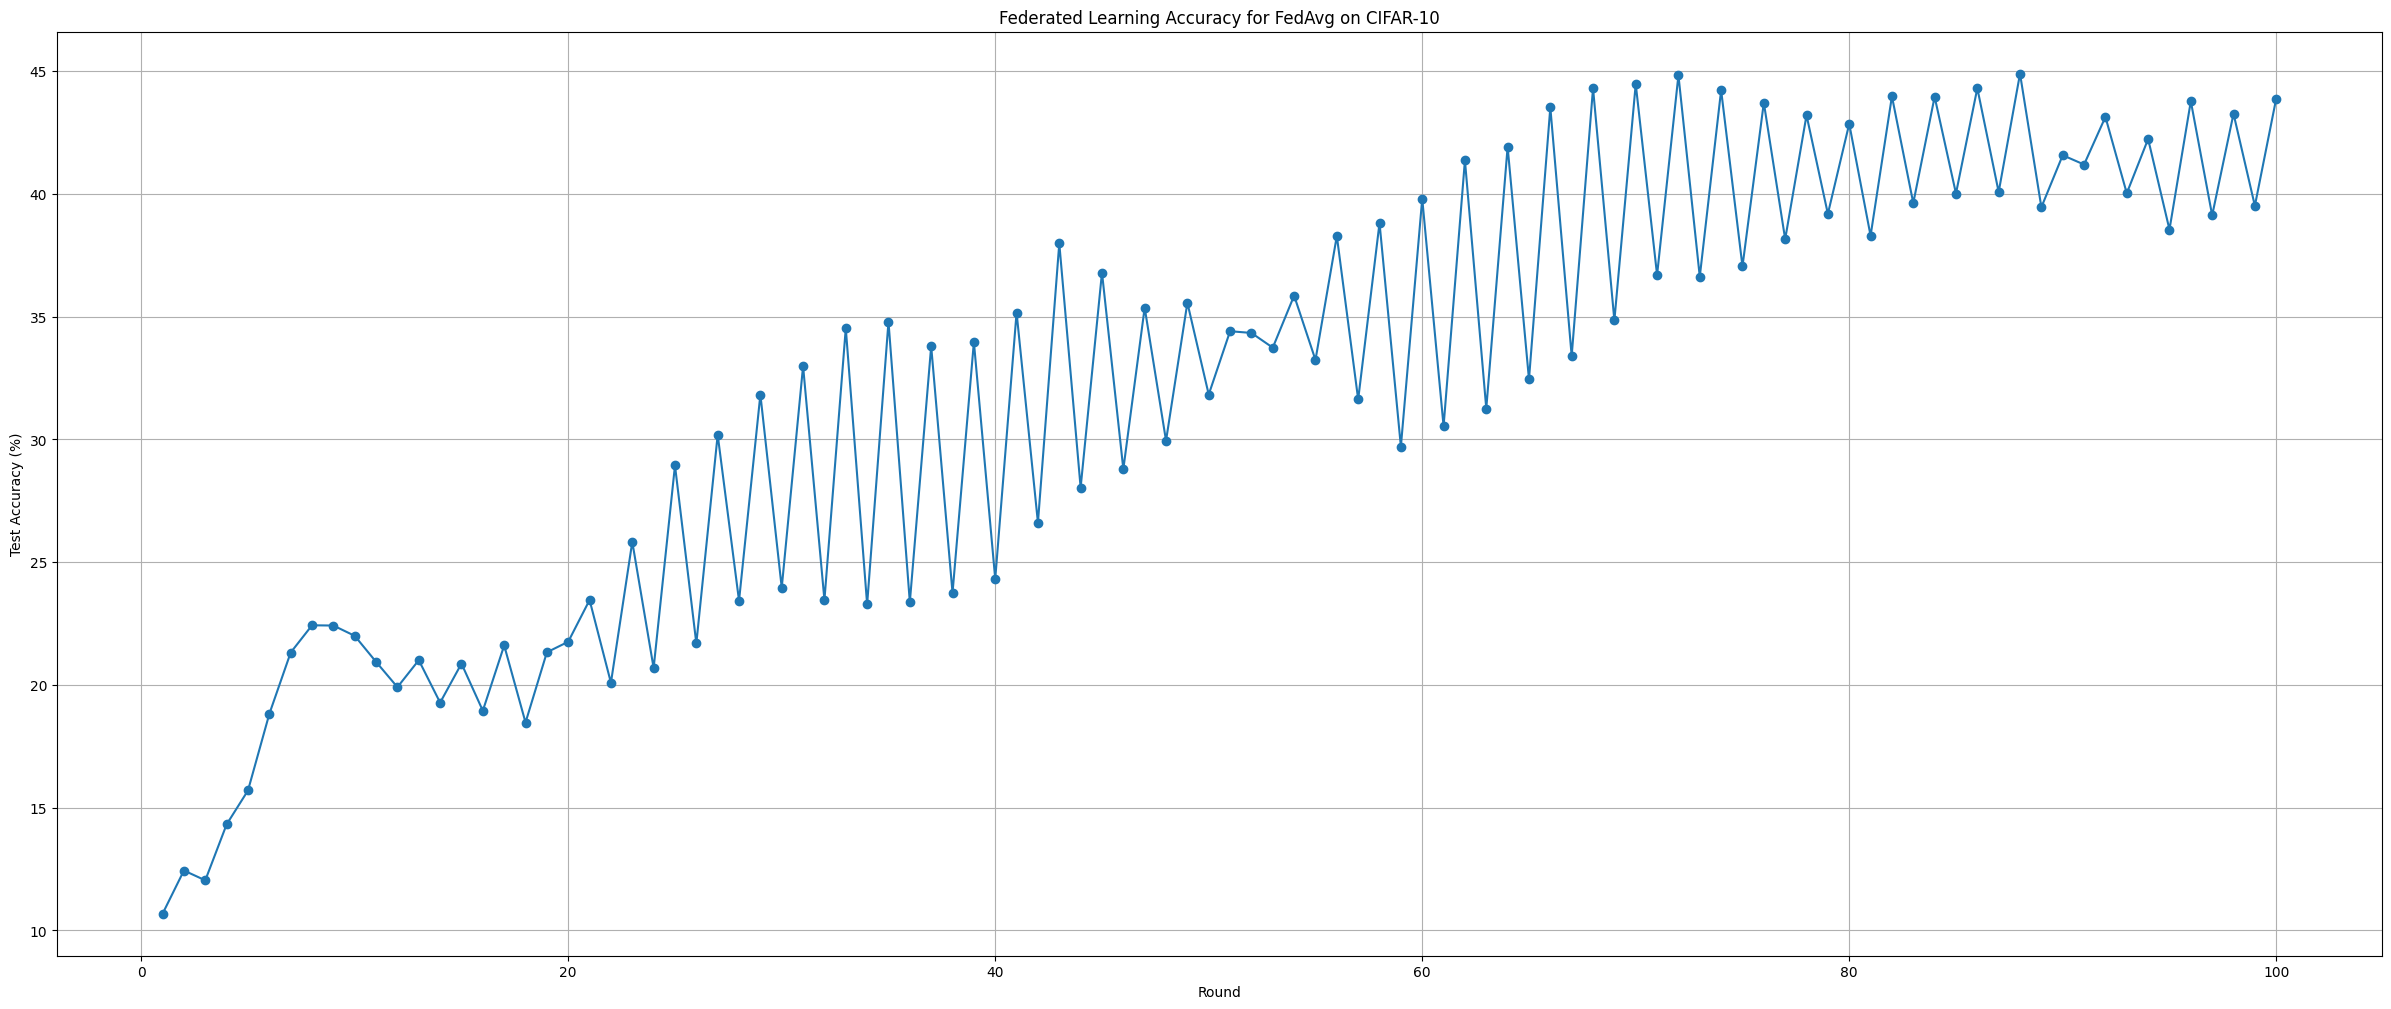

In [ ]:

plt.figure(figsize=(30, 12))
plt.plot(range(1, FL_ROUNDS + 1), global_accuracy_list, marker='o')
plt.xlabel('Round')
plt.ylabel('Test Accuracy (%)')
plt.title('Federated Learning Accuracy for FedAvg on CIFAR-10')
plt.grid(True)
#plt.xticks(range(1, 101))  # Set x-axis from 1 to 20
plt.show()

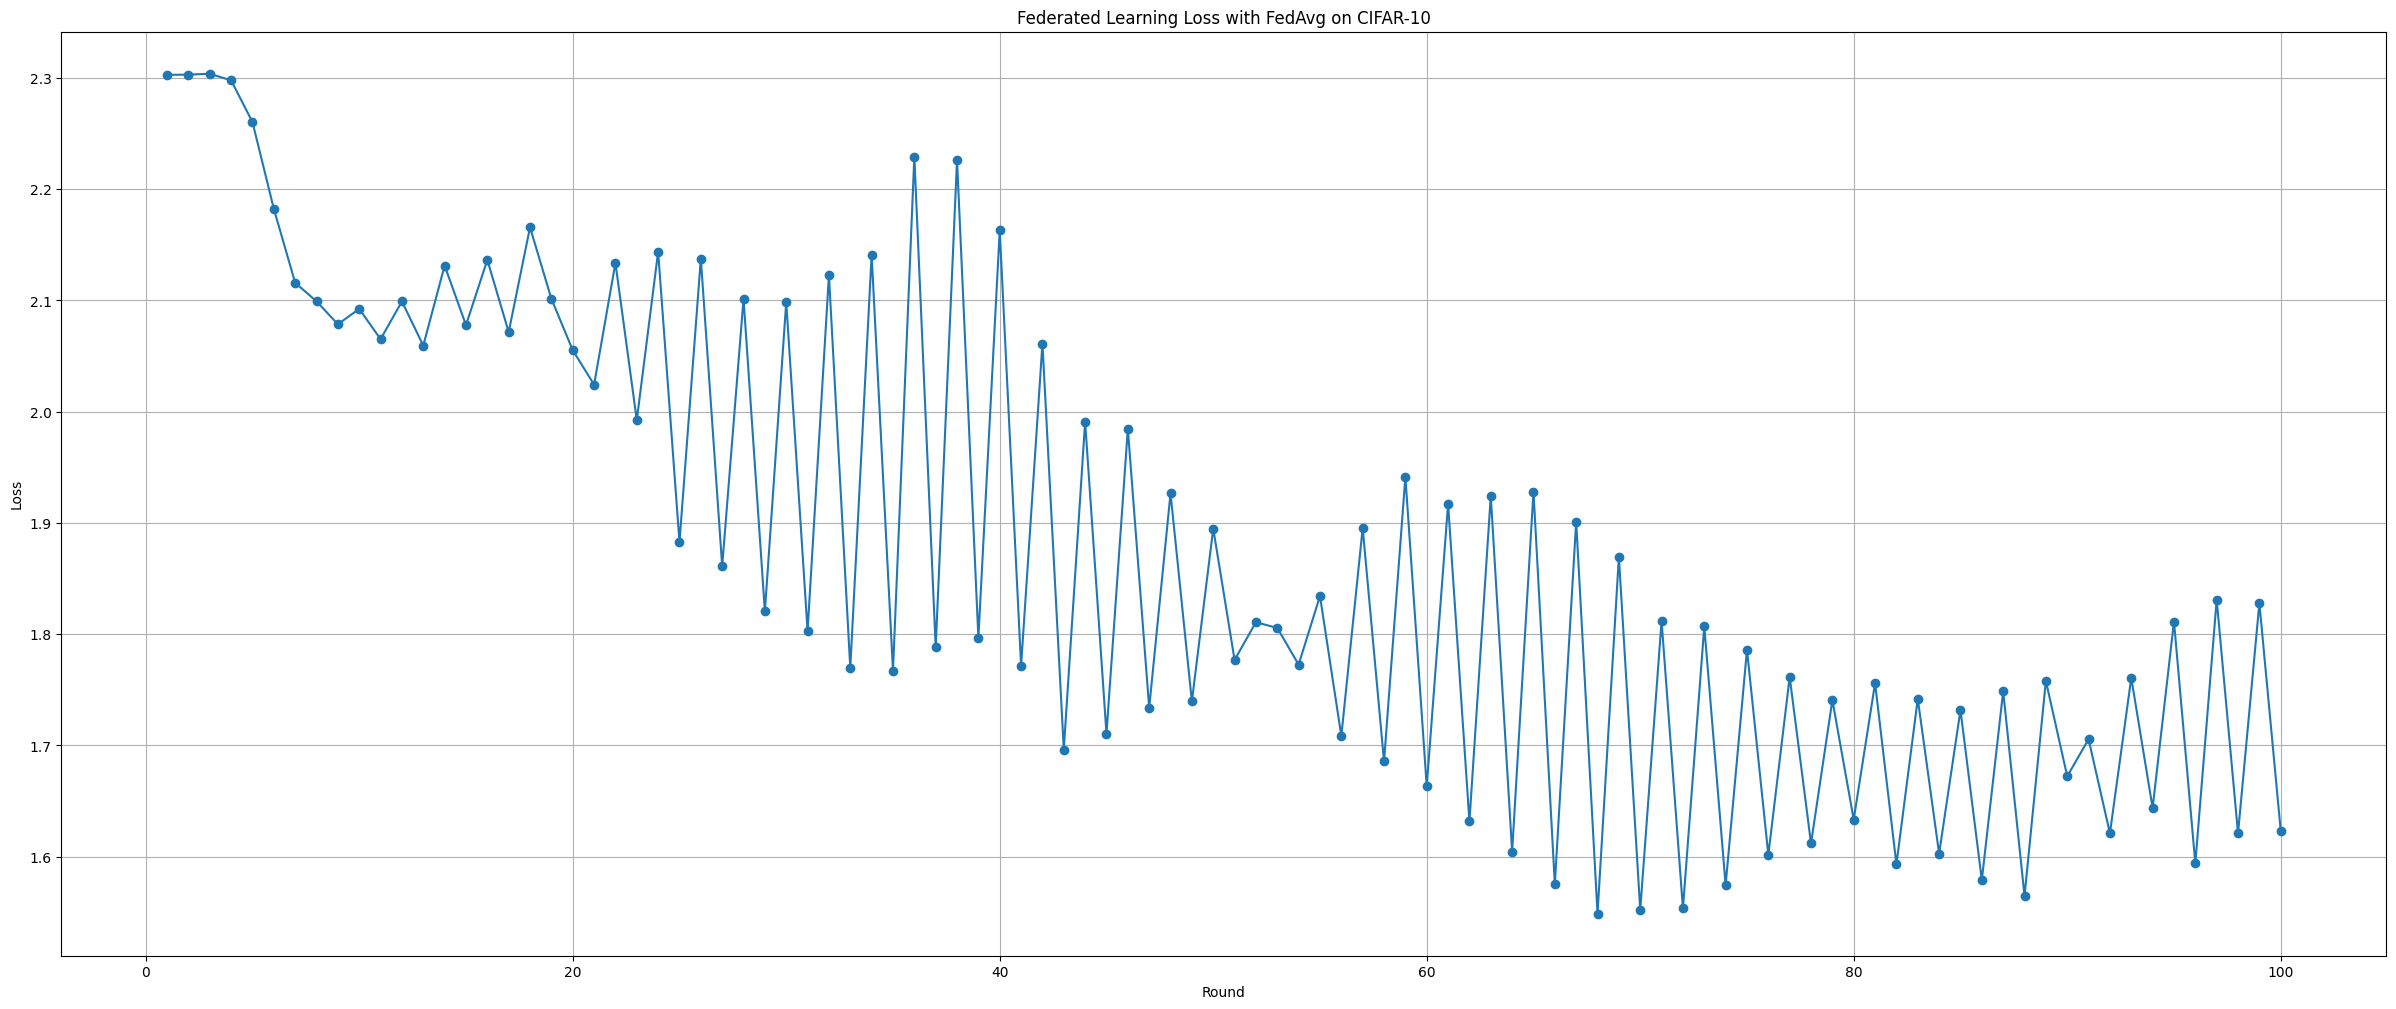

In [ ]:
plt.figure(figsize=(30, 12))
plt.plot(range(1, FL_ROUNDS + 1), global_loss_list, marker='o')
plt.xlabel('Round')
plt.ylabel('Loss')
plt.title('Federated Learning Loss with FedAvg on CIFAR-10')
plt.grid(True)
#plt.xticks(range(1, 101))  # Set x-axis from 1 to 20
plt.show()

In [ ]:
import pickle

with open('/content/drive/MyDrive/Engineering-UOR/Final Year Project/Implementations/EMD IMPL/IID20 C100 NonIID-2Class/history/fedavg/accuracy_history_FL100.pkl', 'wb') as f:
    pickle.dump(global_accuracy_list, f)

with open('/content/drive/MyDrive/Engineering-UOR/Final Year Project/Implementations/EMD IMPL/IID20 C100 NonIID-2Class/history/fedavg/loss_history_FL100.pkl', 'wb') as f:
  pickle.dump(global_loss_list, f)